In [116]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'scripts'))
#print(sys.path)
import utils as u

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import countDistinct, col
import pyspark.sql.functions as F
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sp = (
    SparkSession.builder.appName("merchants")
    .config("spark.sql.session.timeZone", "+11")
    .config("spark.driver.memory", "10g")
    .config("spark.executor.memory", "10g")
    .config('spark.sql.parquet.cacheMetadata', 'True')
    .getOrCreate()
)
sp

22/10/09 18:30:42 WARN Utils: Your hostname, Loky-PC resolves to a loopback address: 127.0.1.1; using 172.25.51.192 instead (on interface eth0)
22/10/09 18:30:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 18:30:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [15]:
full_data = sp.read.parquet("../data/full_dataset/")
fraud_probabilities = sp.read.parquet('../models/random_forest_output_full/')
fraud_probabilities = fraud_probabilities.select('merchant_abn', 'user_id', 'order_datetime', 'prediction')

In [16]:
fraud_probabilities.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- prediction: double (nullable = true)



In [13]:
full_data.printSchema()


root
 |-- order_id: string (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- sa3name: string (nullable = true)
 |-- sa4name: string (nullable = true)
 |-- electoraterating: string (nullable = true)
 |-- SA3_NAME_2016: string (nullable = true)
 |-- electorate: string (nullable = true)
 |-- Number of individuals lodging an income tax return: long (nullable = true)
 |-- Average taxable income or loss: long (nullable = true)
 |-- Median taxable income or loss: long (nullable = true)
 |-- Proportion with salary or wages: long (nullable = true)
 |-- Count salary or wages: long (nullable = true)
 |-- Average salary or wages: l

# Company Basic Selling Performance

total revenue

customer base and distribution
growth
industry


In [23]:
#see the distribution of total revenue
total_revenue = full_data.groupBy(col("merchant_abn")).sum("dollar_value")
total_revenue = total_revenue.withColumnRenamed("sum(dollar_value)", "total_revenue")
total_revenue.count()
total_revenue.printSchema()
total_revenue_df = total_revenue.toPandas()

root
 |-- merchant_abn: long (nullable = true)
 |-- total_revenue: double (nullable = true)



<AxesSubplot: >

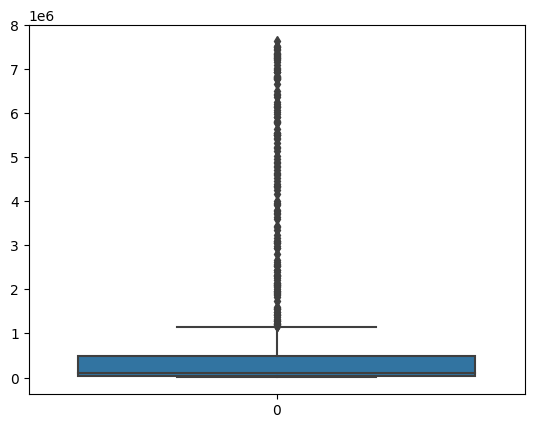

In [34]:
sns.boxplot(total_revenue_df["total_revenue"])

In [42]:
#total num of transactions 
total_transactions = full_data.groupBy(col("merchant_abn")).count()
total_transactions = total_transactions.withColumnRenamed("count", "total_num_transaction")
total_transactions_df = total_transactions.toPandas()

<AxesSubplot: >

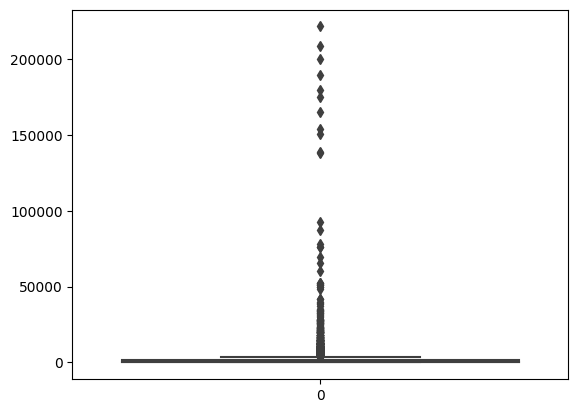

In [45]:
total_transactions_df.head()
sns.boxplot(total_transactions_df["total_num_transaction"])

In [88]:
revenue_numTransac = total_transactions_df.set_index("merchant_abn").join(total_revenue_df.set_index("merchant_abn"))
revenue_numTransac.head()

,total_num_transaction,total_revenue
merchant_abn,,
83412691377,10988,385167.80
38700038932,5511,7346938.26
15613631617,1429,433051.58
73256306726,4117,1204237.54
73841664453,734,63980.31


<AxesSubplot: xlabel='total_num_transaction', ylabel='total_revenue'>

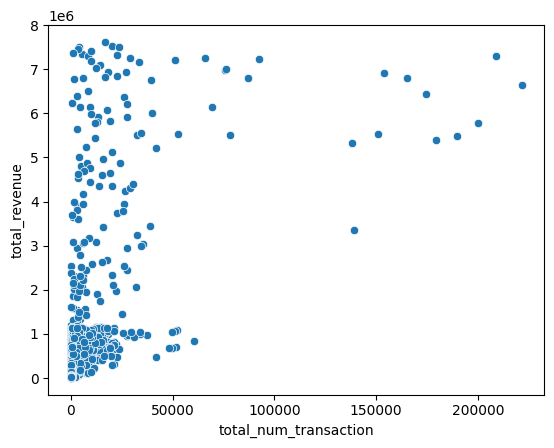

In [51]:
sns.scatterplot(x = revenue_numTransac["total_num_transaction"], y = revenue_numTransac["total_revenue"])

<AxesSubplot: xlabel='total_num_transaction', ylabel='total_revenue'>

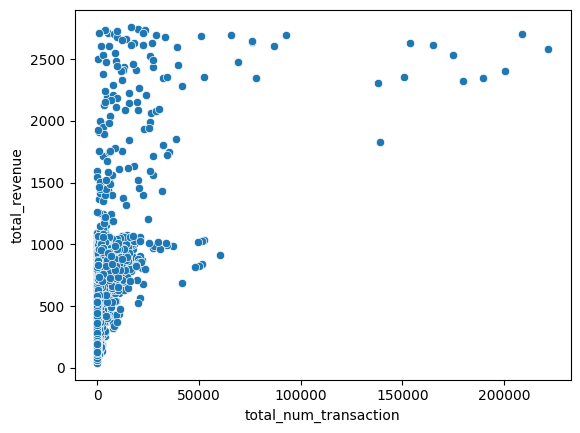

In [90]:
sns.scatterplot(x = revenue_numTransac["total_num_transaction"], y = np.sqrt(revenue_numTransac["total_revenue"]))

<AxesSubplot: xlabel='avg_dollar_value', ylabel='total_num_transaction'>

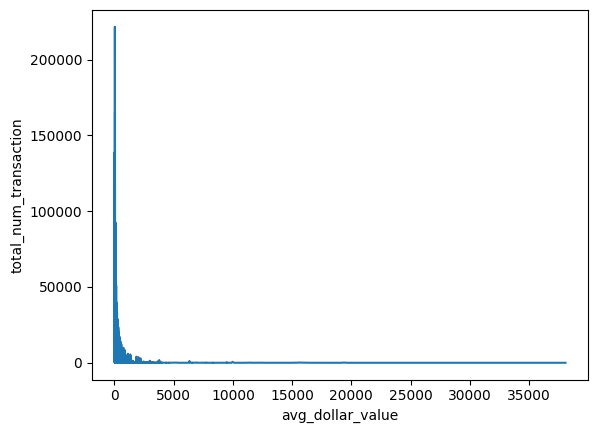

In [137]:
revenue_numTransac["avg_dollar_value"] = revenue_numTransac["total_revenue"]/revenue_numTransac["total_num_transaction"]
sns.lineplot(x = revenue_numTransac["avg_dollar_value"], y = revenue_numTransac["total_num_transaction"])

<AxesSubplot: xlabel='avg_dollar_value', ylabel='total_revenue'>

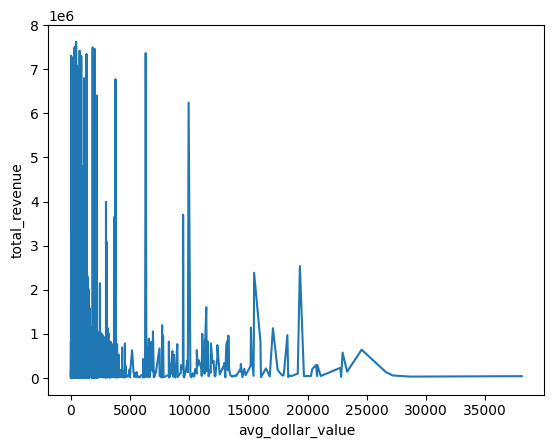

In [54]:
sns.lineplot(x = revenue_numTransac["avg_dollar_value"], y = revenue_numTransac["total_revenue"])

In [91]:
#see the distribution of the high revenue companies
money_makers = total_revenue.filter(col("total_revenue") > 1000000)
money_makers = money_makers.distinct()
print("number of very high revenue: ", money_makers.count())
print("the percentage: ", money_makers.count()/total_revenue.count())
money_makers = money_makers.toPandas()

number of very high revenue:  322


the percentage:  0.0801792828685259


In [ ]:
descriptions = full_data.select("merchant_abn", "Description", "Earnings_Class","BNPL_Revenue")
descriptions = descriptions.drop_duplicates(["merchant_abn", "Description"])
descriptions.count()
descriptions = descriptions.toPandas()

In [ ]:
#focus on the high revnue ones
money_makers_info = money_makers.set_index("merchant_abn").join(descriptions.set_index("merchant_abn"))



total_revenue     322
Description       322
Earnings_Class    322
BNPL_Revenue      322
dtype: int64

Text(0, 0.5, 'number of companies')

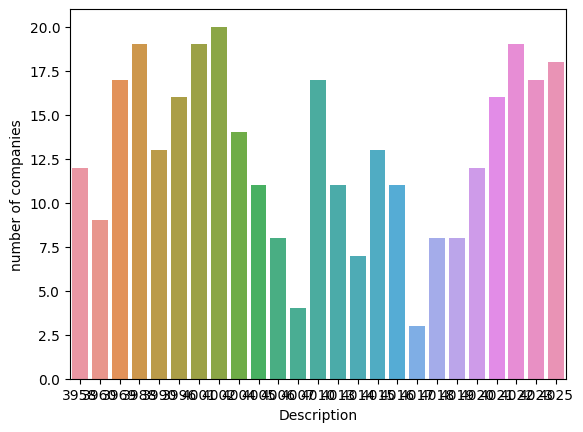

In [ ]:
from matplotlib.pyplot import ylabel


by_industry_count = money_makers_info.groupby("Description").agg("count")
by_industry_count = by_industry_count.sort_values(by = "total_revenue")

sns.barplot(x = by_industry_count.index, y = by_industry_count.sort_values("total_revenue").total_revenue)
plt.ylabel("number of companies")

<AxesSubplot: ylabel='total_revenue'>

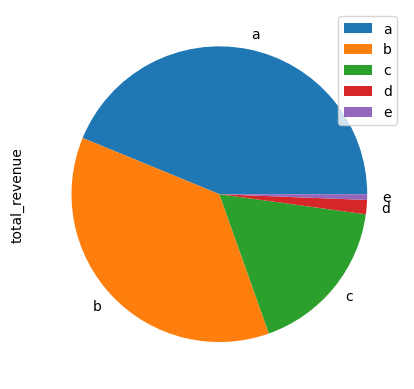

In [ ]:
by_Eclass_count = money_makers_info.groupby("Earnings_Class").count()
by_Eclass_count.plot.pie(y = "total_revenue")

In [ ]:
merchants = sp.read.parquet("../data/tables/processed/merchants/")
merchants.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- avg_monthly_inc: float (nullable = true)
 |-- monthly_entropy: float (nullable = true)
 |-- postcode_entropy: float (nullable = true)
 |-- revenue: double (nullable = true)



In [122]:
money_makers = total_revenue.filter(col("total_revenue") > 1000000)
money_makers = money_makers.distinct()
merchants = sp.read.parquet("../data/tables/processed/merchants/")
please_let_me = merchants.join(money_makers)


# Customer base analysis


In [127]:
total_unique = full_data.groupBy("merchant_abn").agg(F.countDistinct(F.col("consumer_id")))
total_unique.show()
#sns.histplot(total_unique.toPandas()[])

+------------+------------------+
|merchant_abn|count(consumer_id)|
+------------+------------------+
| 73256306726|              3144|
| 15613631617|              1150|
| 38700038932|              4140|
| 83412691377|              7621|
| 48214071373|               321|
| 73841664453|               578|
| 52763133264|                88|
| 35344855546|               952|
| 41956465747|               180|
| 19839532017|               467|
| 12516851436|               134|
| 96946925998|                85|
| 34440496342|               137|
| 37935728745|                11|
| 92202115241|                75|
| 38986645707|                23|
| 60654402457|               115|
| 78916025936|                40|
| 57798993346|                 9|
| 59128133246|              3779|
+------------+------------------+
only showing top 20 rows



<AxesSubplot: xlabel='unqie_customers', ylabel='total_num_transaction'>

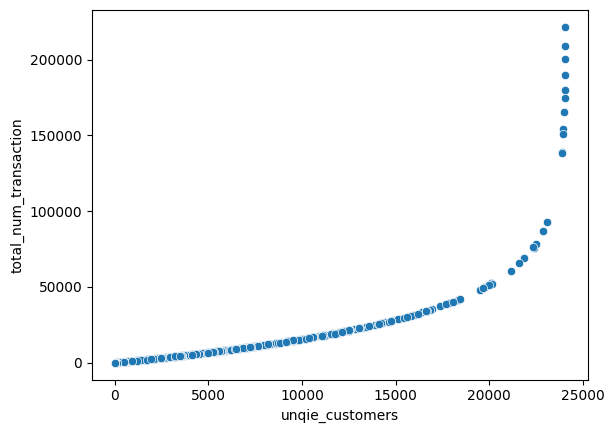

In [138]:
customer_joined = total_unique.toPandas().set_index("merchant_abn").join(revenue_numTransac)
customer_joined["unqie_customers"] = customer_joined["count(consumer_id)"]
sns.scatterplot(x = customer_joined["unqie_customers"], y = customer_joined["total_num_transaction"])

<AxesSubplot: xlabel='unqie_customers', ylabel='total_revenue'>

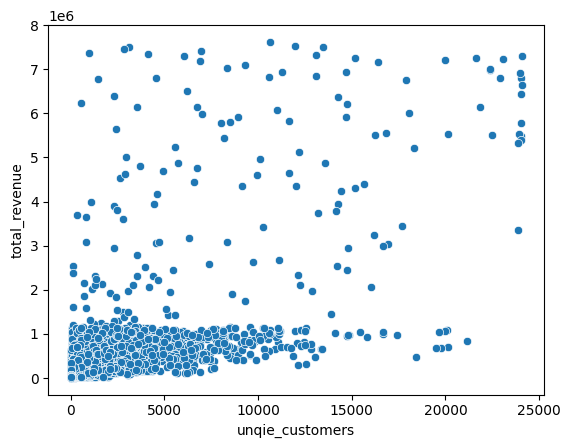

In [132]:
sns.scatterplot(x = customer_joined["unqie_customers"], y = customer_joined["total_revenue"])

<AxesSubplot: xlabel='avg_dollar_value', ylabel='unqie_customers'>

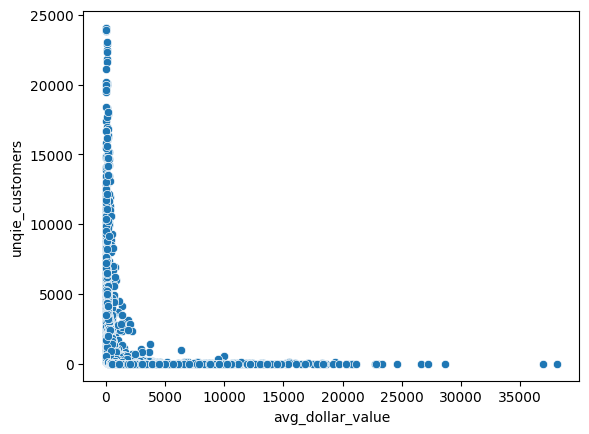

In [141]:
customer_joined.head()
sns.scatterplot(y = customer_joined["unqie_customers"], x = customer_joined["avg_dollar_value"])